In [1]:
import pandas as pd
import numpy as np
from copy import copy
import torch
import matplotlib.pyplot as plt


In [2]:
def file_to_data(filename):
    
    # read file
    raw = pd.read_csv(filename)
    
    # define columns to be extracted
    ndvi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., ndvi_mean24
    savi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., savi_mean24
    evi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., evi_mean24

    # extract each feature
    ndvi_timeseries = raw[ndvi_col]
    savi_timeseries = raw[savi_col]
    evi_timeseries = raw[evi_col]
    
    # dimension stack
    data = np.dstack([ndvi_timeseries, savi_timeseries, evi_timeseries])
    
    # get only label
    label = raw.iloc[:, -1]
    
    return data, label

def data_to_lv1_x_y(data, labels):
    
    # export all X
    # but reclass the plant cane -> 100, ratoon cane -> 200
    target = copy(labels)
    target[target > 200] = 200
    target[(target < 200) & (target > 100)] = 100
    
    return data, target

def data_to_lv2_x_y(data, target):
    
    # export X plant which labels are 100-200
    X_plant = data[(target > 100) & (target <200)]
    
    # export X ratoon which labels are >200
    X_ratoon = data[target > 200]
    
    # export y plant which labels are 100-200
    y_plant = target[(target > 100) & (target < 200)]
    
    # export y ratoon which labels are >200
    y_ratoon = target[target > 200]
    
    return X_plant, y_plant, X_ratoon, y_ratoon

def label_encode(y):
    
    target = copy(y)
    # redefine the cane plantation label to be 1 - 24
    new_y = [int(str(label)[1:]) for label in target]
    
    return np.array(new_y)

In [3]:
data_train, labels_train = file_to_data('training_data_1718.csv')
data_test, labels_test = file_to_data('training_data_1819.csv')

In [4]:
X_plant_train, y_plant_train, X_ratoon_train, y_ratoon_train = data_to_lv2_x_y(data_train, labels_train)
X_plant_test, y_plant_test, X_ratoon_test, y_ratoon_test = data_to_lv2_x_y(data_test, labels_test)

In [5]:
def makelabel(y):
    y = y.to_numpy()
    for i in range(len(y)):
        if y[i] %100 >0 and y[i] %100<=2:
              y[i] = 0 
        elif y[i] %100>2 and y[i] %100<=4:
              y[i] = 1 
        elif y[i] %100>4 and y[i] %100<=6:
              y[i] = 2 
        elif y[i] %100>6 and y[i] %100<=8:
              y[i] = 3                 
        elif y[i] %100>8 and y[i] %100<=10:
              y[i] = 4 
        elif y[i] %100>20 and y[i] %100<=22:
              y[i] = 10 
        elif y[i] %100>22 and y[i] %100<=24:
              y[i] = 11           
    return y
y_plant_train = makelabel(y_plant_train)
y_ratoon_train = makelabel(y_ratoon_train)

y_plant_test = makelabel(y_plant_test)
y_ratoon_test = makelabel(y_ratoon_test)

In [6]:
print(f'numeric class of y train: {np.unique(y_plant_train)}')
print(f'numeric class of y test: {np.unique(y_plant_test)}')

numeric class of y train: [ 0  1  2  3 10 11]
numeric class of y test: [ 0  1  2  3 10 11]


In [7]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [8]:
X_plant_train = X_plant_train.reshape(X_plant_train.shape[0], -1)
X_ratoon_train = X_ratoon_train.reshape(X_ratoon_train.shape[0], -1)
print(f'X plant train: {X_plant_train.shape}')
print(f'X ratoon train: {X_ratoon_train.shape}')

X plant train: (4489, 72)
X ratoon train: (7878, 72)


In [9]:
# instantiating the random over sampler 
ros = RandomOverSampler()
# resampling X, y
X_plant_train, y_plant_train = ros.fit_resample(X_plant_train, y_plant_train)
X_ratoon_train, y_ratoon_train = ros.fit_resample(X_ratoon_train, y_ratoon_train)

print(f'after oversampled-> X plant shape: {X_plant_train.shape}')
print(f'after oversampled-> X ratoon shape: {X_ratoon_train.shape}')

after oversampled-> X plant shape: (10206, 72)
after oversampled-> X ratoon shape: (17650, 72)


In [10]:
X_plant_train = X_plant_train.reshape(X_plant_train.shape[0], 24,3)
X_ratoon_train = X_ratoon_train.reshape(X_ratoon_train.shape[0], 24,3)

print(f'X plant train: {X_plant_train.shape}')
print(f'X ratoon train: {X_ratoon_train.shape}')

X plant train: (10206, 24, 3)
X ratoon train: (17650, 24, 3)


In [11]:
X_plant_train = X_plant_train.transpose(0,2,1)
X_ratoon_train = X_ratoon_train.transpose(0,2,1)

In [12]:
print(f'y plant train: {y_plant_train.shape}')
print(f'y ratoon train: {y_ratoon_train.shape}')

y plant train: (10206,)
y ratoon train: (17650,)


In [13]:
X_plant_train = X_plant_train[:,:,:14] # pick only 7 month because It dont plant after april.
X_ratoon_train = X_ratoon_train[:,:,:14]
print(f'X plant train: {X_plant_train.shape}')
print(f'X ratoon train: {X_ratoon_train.shape}')

X plant train: (10206, 3, 14)
X ratoon train: (17650, 3, 14)


In [14]:
x_mix = np.concatenate((X_plant_train, X_ratoon_train), axis=0)
y_mix = np.concatenate((y_plant_train, y_ratoon_train), axis=0)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(x_mix, y_mix  , test_size=0.3)

In [16]:
X_train_ndvi = X_train[:,0,:]
X_valid_ndvi = X_valid[:,0,:]
X_train_savi = X_train[:,1,:]
X_valid_savi = X_valid[:,1,:]
X_train_evi = X_train[:,2,:]
X_valid_evi = X_valid[:,2,:]

In [17]:
from sklearn.svm import SVC # "Support vector classifier"
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

#select the type of hyperplane used to separate the data
kernel = ['linear', 'rbf']

#regularized penalty
#when C is small, classifier is ok with misclassified data
#when C is large, classifier is heavily penalized for misclassified data
C_range = [1, 2]

#parameter for RBF kernel, increasing gamma
#allows for more complex decision boundary but can lead
#to overfitting
gamma_range = [0.0001, 0.0005]

param_grid = dict(gamma=gamma_range, C=C_range, kernel=kernel)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train_ndvi, y_train)

print("=========Best parameters=======")
print(f"The best parameters are {grid.best_params_} with" +
          f"a score of {grid.best_score_:.2f}")

model = grid.best_estimator_

model.fit(X_train_ndvi, y_train)
yhat = model.predict(X_valid_ndvi) #svm use this instead

#plot precision recall curve
from sklearn.metrics import average_precision_score, classification_report, confusion_matrix
print("=========Classification report=======")
print("Report: ", classification_report(y_valid, yhat))


=========Best parameters=======
The best parameters are {'C': 2, 'gamma': 0.0001, 'kernel': 'linear'} witha score of 0.62
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.53      0.68      0.60      1658
           1       0.52      0.37      0.43      1580
           2       0.53      0.29      0.38      1519
           3       0.66      0.69      0.67      1536
          10       0.90      0.93      0.91       496
          11       0.71      0.97      0.82      1568

    accuracy                           0.62      8357
   macro avg       0.64      0.66      0.64      8357
weighted avg       0.61      0.62      0.60      8357



In [18]:
X_plant_test = X_plant_test.transpose(0,2,1)[:,:,:14]
X_ratoon_test = X_ratoon_test.transpose(0,2,1)[:,:,:14]
x_mix_test = np.concatenate((X_plant_test, X_ratoon_test), axis=0)
y_mix_test = np.concatenate((y_plant_test, y_ratoon_test), axis=0)
X_test_ndvi = x_mix_test[:,0,:]

In [19]:
y_preds = model.predict(X_test_ndvi)
print(classification_report(y_mix_test, y_preds))

              precision    recall  f1-score   support

           0       0.24      0.46      0.32       898
           1       0.48      0.34      0.40      2163
           2       0.61      0.29      0.40      2410
           3       0.60      0.70      0.65      1729
          10       0.12      1.00      0.21         3
          11       0.23      0.93      0.37       249

    accuracy                           0.44      7452
   macro avg       0.38      0.62      0.39      7452
weighted avg       0.51      0.44      0.45      7452



Text(33.0, 0.5, 'predicted')

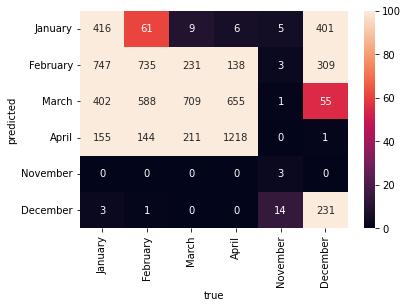

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix_plant = confusion_matrix(y_mix_test, y_preds)
xticklabels = ["January", "February", "March", "April", "November", "December"]
yticklabels = ["January", "February", "March", "April", "November", "December"]

sns.heatmap(cf_matrix_plant, fmt="d",vmax=100 ,annot=True,xticklabels=xticklabels, yticklabels=yticklabels)
plt.xlabel('true')
plt.ylabel('predicted')